### Metode Istraživanja i Eksploatacije Podataka
- Student: **Elena Dejanović** IT42/2019
- Tema: Statua Jovana Jovanovića Zmaja

Potrebne biblioteke:

In [35]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
import json
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

Statične lokacije:

In [37]:

annotations_file = "annotations.json"
images_dir = "images/"


Priprema podataka:

In [38]:

roi_data = {}

with open(annotations_file, 'r') as f:
    annotations_data = json.load(f)

for annotation in annotations_data['annotations']:
    image_id = annotation['image_id']
    image_info = next(img for img in annotations_data['images'] if img['id'] == image_id)
    image_filename = image_info['file_name']
    image_path = os.path.join(images_dir, image_filename)
    
    img = cv2.imread(image_path)
    if img is None:
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    masks = []
    for segmentation in annotation['segmentation']:
        pts = np.array(segmentation, np.float32).reshape((-1, 1, 2))
        pts = np.round(pts).astype(np.int32)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [pts], color=255)
        masks.append(mask)
    
    mask_stack = np.stack(masks, axis=-1)
    
    roi_data.setdefault(image_filename, []).append((img, mask_stack))


Definicija modela:

In [39]:
input_size=(200, 200, 3)

# Input layer
net_input = layers.Input(input_size)

# First convolutional block
conv1 = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(net_input)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Dropout(rate=0.1)(conv1)
conv1 = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

# Second convolutional block
conv2 = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Dropout(rate=0.1)(conv2)
conv2 = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Upsampling and third convolutional block
upsample3 = layers.UpSampling2D(size=(2, 2))(pool2)
merge3 = layers.concatenate([upsample3, conv2])
conv3 = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Dropout(rate=0.1)(conv3)
conv3 = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

# Upsampling and fourth convolutional block
upsample4 = layers.UpSampling2D(size=(2, 2))(conv3)
merge4 = layers.concatenate([upsample4, conv1])
conv4 = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Dropout(rate=0.1)(conv4)
conv4 = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

# Output layer
net_output = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(conv4)

# Compile model
model = Model(inputs=net_input, outputs=net_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 200, 200, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 200, 200, 32)         128       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_4 (Dropout)         (None, 200, 200, 32)         0         ['batch_normalization_4[

Treniranje modela:

In [43]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 200, 200

# Helper function for resizing and normalizing images and masks
def process_images_and_masks(images, masks):
    resized_images = [cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) for img in images]
    resized_masks = [cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) for mask in masks]
    
    normalized_images = np.array(resized_images).astype('float32') / 255.0
    normalized_masks = np.array(resized_masks).astype('float32') / 255.0
    
    return normalized_images, normalized_masks

# Split data into training and testing sets
roi_data_items = list(roi_data.items())
train_data, test_data = train_test_split(roi_data_items, test_size=0.2, random_state=128)

# Extract images and masks from training and testing sets
train_images, train_masks = zip(*[(img, mask) for img_filename, roi in train_data for img, mask in roi])
test_images, test_masks = zip(*[(img, mask) for img_filename, roi in test_data for img, mask in roi])

# Process training and testing images and masks
x_train, y_train = process_images_and_masks(train_images, train_masks)
x_val, y_val = process_images_and_masks(test_images, test_masks)

# Train the model
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=100)
model.save('model.h5')


Epoch 1/60
2/2 [==============================] - 9s 3s/step - loss: 0.1800 - accuracy: 0.9292 - val_loss: 0.7986 - val_accuracy: 0.6182
Epoch 2/60
2/2 [==============================] - 11s 4s/step - loss: 0.1835 - accuracy: 0.9245 - val_loss: 0.7976 - val_accuracy: 0.6188
Epoch 3/60
2/2 [==============================] - 12s 4s/step - loss: 0.1701 - accuracy: 0.9319 - val_loss: 0.7530 - val_accuracy: 0.6266
Epoch 4/60
2/2 [==============================] - 11s 3s/step - loss: 0.1699 - accuracy: 0.9340 - val_loss: 0.7846 - val_accuracy: 0.6055
Epoch 5/60
2/2 [==============================] - 11s 3s/step - loss: 0.1938 - accuracy: 0.9219 - val_loss: 0.8628 - val_accuracy: 0.5999
Epoch 6/60
2/2 [==============================] - 11s 3s/step - loss: 0.1627 - accuracy: 0.9335 - val_loss: 0.8037 - val_accuracy: 0.6021
Epoch 7/60
2/2 [==============================] - 11s 3s/step - loss: 0.1736 - accuracy: 0.9275 - val_loss: 0.7452 - val_accuracy: 0.6229
Epoch 8/60
2/2 [===================

2/2 [==============================] - 11s 4s/step - loss: 0.1321 - accuracy: 0.9464 - val_loss: 0.6737 - val_accuracy: 0.7225


C:\Users\ofidi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Prikaz rezultata:

1/1 [==============================] - 0s 408ms/step
Precision: 0.6570
Recall: 0.6256
F1-score: 0.6409


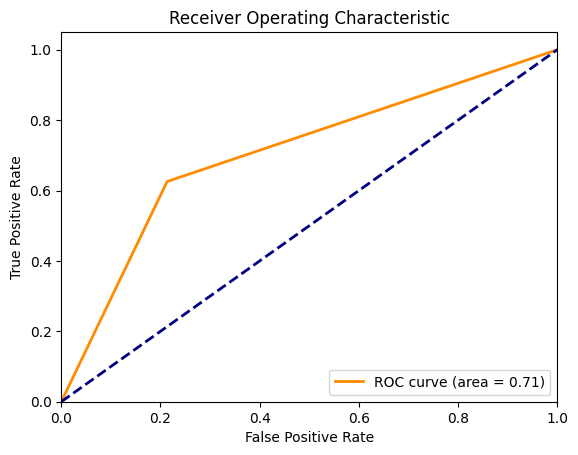

In [44]:
IMG_HEIGHT, IMG_WIDTH = 200, 200

# Helper function for resizing and normalizing a single image
def process_image(image):
    resized_image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image

# Helper function to apply the model to a batch of images
def predict_masks(images):
    return model.predict(images)

# Process testing images
x_test = np.array([process_image(img) for img in test_images])

# Make predictions
y_pred_masks = predict_masks(x_test)

y_pred_masks_binary = (y_pred_masks > 0.5).astype('float32')
y_true_binary = (y_val > 0.5).astype('float32')

# Flatten the true masks and predicted masks
y_true = y_true_binary.reshape(-1)
y_pred = y_pred_masks_binary.reshape(-1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()